#  Прогнозирование заказов такси

**Задача:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

**Условия:**

- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
- Размер тестовой выборки - 10% от исходных данных.

**Описание данных:**

- Данные лежат в файле `taxi.csv`.
- Количество заказов находится в столбце `num_orders`.

**Краткий план действий:**

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами.
4. Проверим лучшую модель на тестовой выборке.


## Подготовка

In [ ]:
# загружаем необходимы библиотеки и модули

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


warnings.filterwarnings("ignore", category=FutureWarning)

Загрузим данные, столбец с датой установим в качестве индекса и одновременно с этим изменим тип данных на *datetime64*:

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

Выведем первые 5 строк датасета:

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположены дата и время:

In [ ]:
print(data.index.is_monotonic_increasing)

True


Выведем общую информацию о датасете:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Агрегация данных была произведена с интервалом в 10 минут - данные слишком подробны, ресемплируем их по одному часу:

In [ ]:
# меняем интервал ряда и суммируем количество заказов
data_1h = data.resample('1H').sum()
data_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

1. Предоставленный датасет содержит данные количества заказов такси с марта по август 2018 г.
2. Интервал данных - 10 минут, было произведено ресемплирование по одному часу.
3. Данные расположены в хронологическом порядке.

## Анализ

### Скользящее среднее и стандартное отклонение

Посмотрим на скользящее среднее и стандартное отклонение ряда:

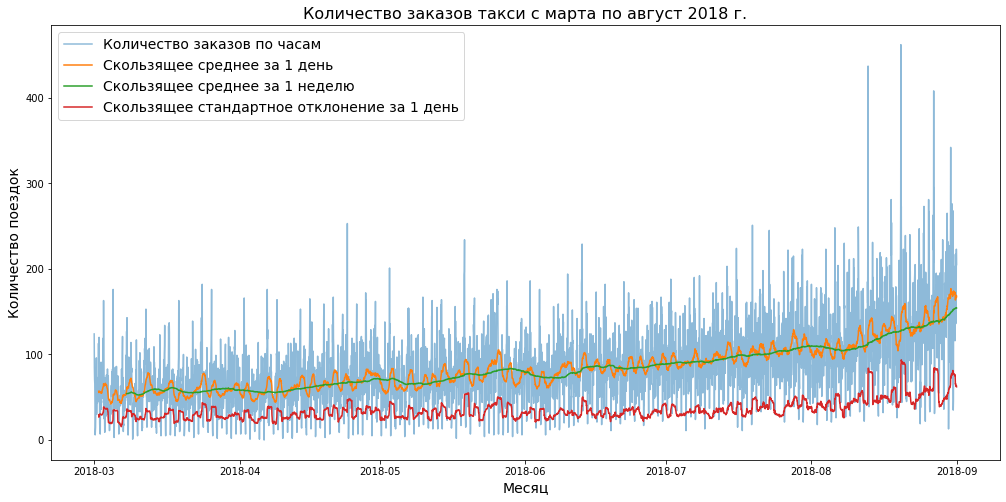

In [ ]:
# зададим размер графика
plt.figure(figsize = (17,8))

# поочередно зададим кривые
plt.plot(data_1h, label = 'Количество заказов по часам', alpha = 0.5)
plt.plot(data_1h.rolling(24).mean(), label = 'Скользящее среднее за 1 день')
plt.plot(data_1h.rolling(24*7).mean(), label = 'Скользящее среднее за 1 неделю')
plt.plot(data_1h.rolling(24).std(), label = 'Скользящее стандартное отклонение за 1 день')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.xlabel('Месяц', fontsize = 14)
plt.ylabel('Количество поездок', fontsize = 14)
plt.title('Количество заказов такси с марта по август 2018 г.', fontsize = 16)

plt.show()

Скользящее среднее за одну неделю демонстрирует плавный рост количества заказов - возможный индикатор планомерного развития компании. Кроме того, наблюдаются небольшие колебания стандартного отклонения, требуется проверка временного ряда на стационарность.

### Разложение ряда на компоненты

Разложим ряд на тренд, сезонность и случайные колебания:

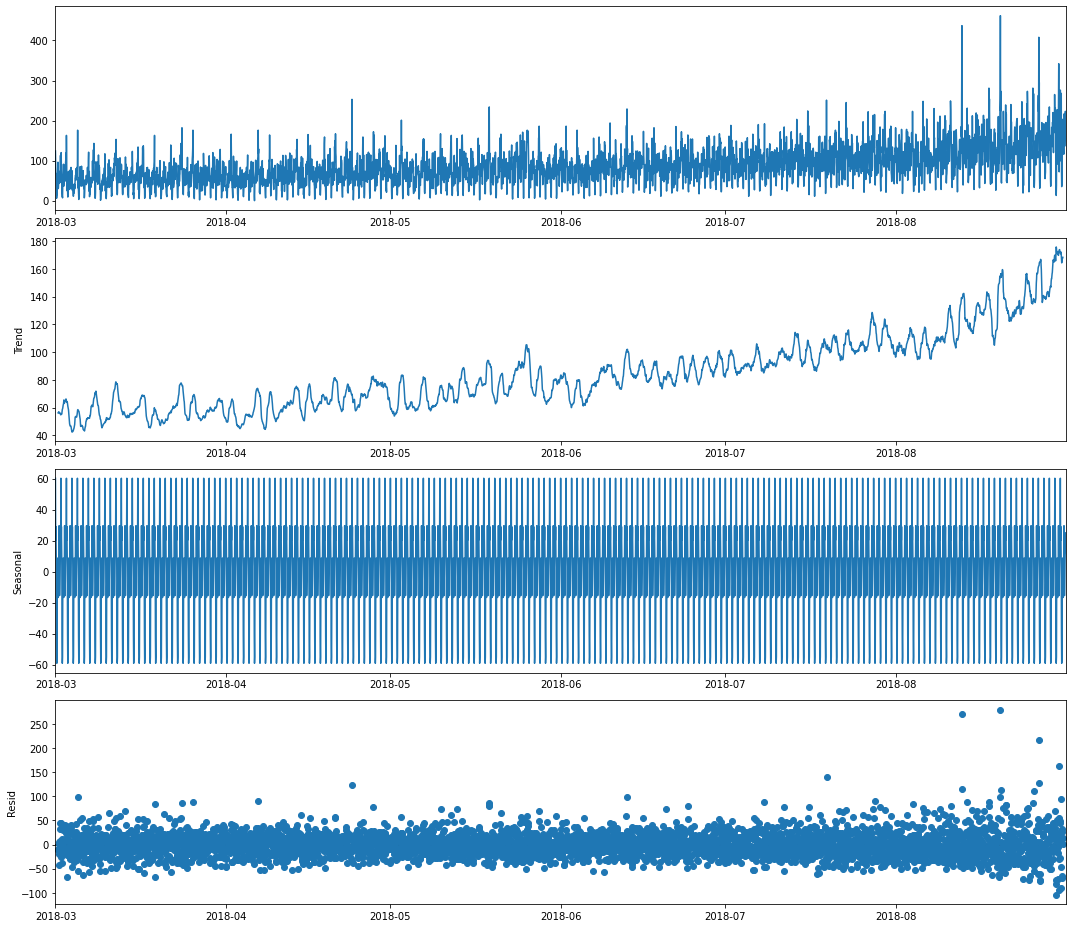

In [ ]:
rcParams['figure.figsize'] = 15, 13
decomposed_1h = seasonal_decompose(data_1h)
decomposed_1h.plot()
plt.show()

Общий тренд подтвердился - количество заказов постепенно увеличивается. График сезонности при данных интервалах не имеет никакой информационной значимости.

Сравним сезонную компоненту для первой половины марта и первой половины августа:

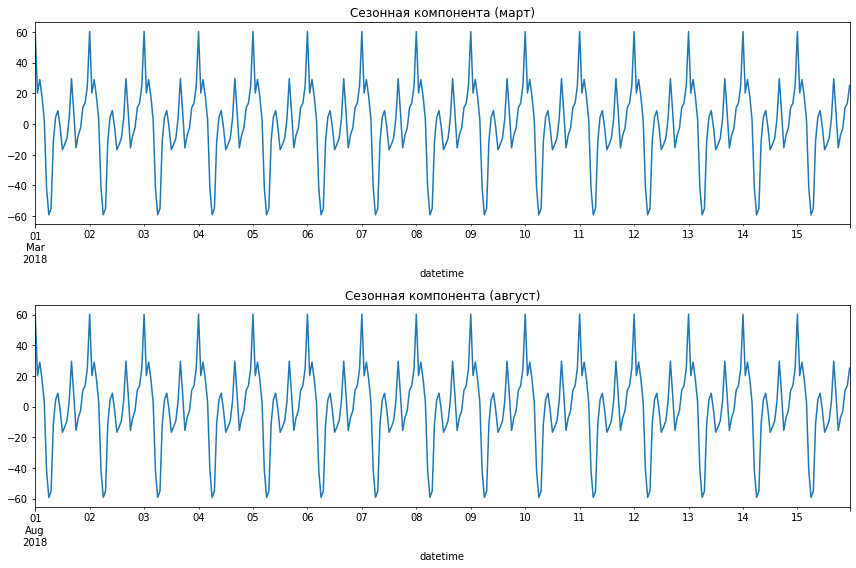

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# первые 15 дней марта
decomposed_1h.seasonal['2018-03-01':'2018-03-15'].plot(ax=ax1)
ax1.set_title('Сезонная компонента (март)')

# первые  15 дней августа
decomposed_1h.seasonal['2018-08-01':'2018-08-15'].plot(ax=ax2)
ax2.set_title('Сезонная компонента (август)')

plt.tight_layout()
plt.show()

На графиках видно, что вечером и до полуночи каждого дня количество заказов возрастает, а затем резко снижается. Для детальной разбивки по времени возьмем 3 дня мая:

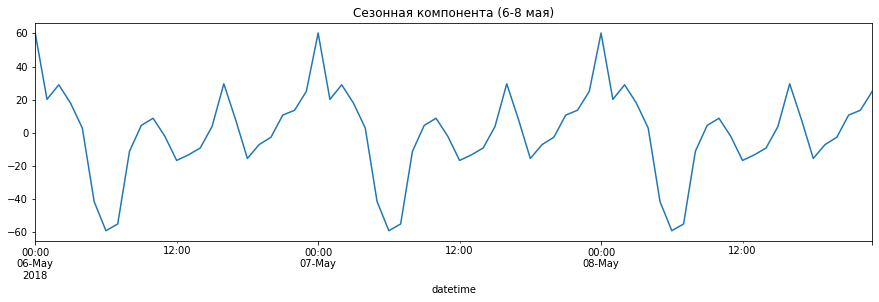

In [ ]:
decomposed_1h.seasonal['2018-05-06':'2018-05-08'].plot(figsize=(15,4))
plt.title('Сезонная компонента (6-8 мая)')
plt.show()

Выводы подтверждаются - к концу дня спрос на услуги такси повышается, а ночью он падает.

Ресемплируем датасет по дням и проанализируем месячную сезонную компоненту:

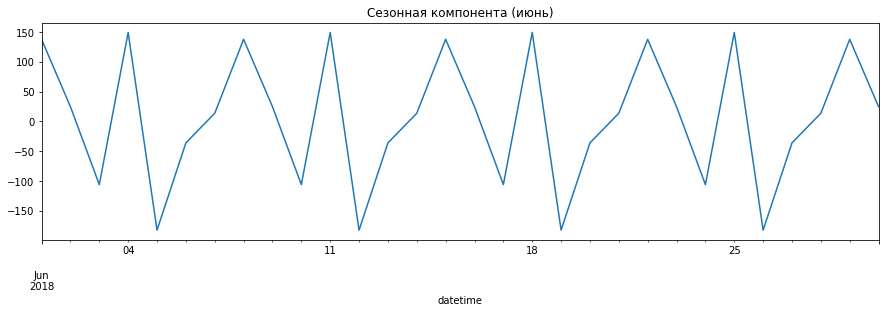

In [ ]:
data_1d = data.resample('1D').sum()
decomposed_1d = seasonal_decompose(data_1d)
decomposed_1d.seasonal['2018-06-01':'2018-06-30'].plot(figsize=(15,4))
plt.title('Сезонная компонента (июнь)')
plt.show()

На графике можно заметить следующие особенности:
- наибольший спрос на услуги такси в понедельник и пятницу;
- наименьший спрос - во вторник и воскресенье.

### Проверка ряда на стационарность

Проверим ряд на стационарность **тестом Дикки-Фуллера**. Сформулируем гипотезы:

- **H0**: нулевая гипотеза предполагает, что ряд нестационарный.
- **H1**: альтернативная гипотеза предполагает, что ряд стационарный.

P-value возьмем равным 0.05

In [ ]:
# передадим столбец с данными о заказах в функцию и поместим результат в adf_test
adf_test = adfuller(data_1h['num_orders'])

# выведем результаты теста
print('p-value = ', adf_test[1])

if adf_test[1] <= 0.05:
    print('Отвергаем нулевую гипотезу, ряд стационарный.')
else:
    print('Не удалось отвергнуть нулевую гипотезу, ряд нестационарный.')

p-value =  0.028940051402612906
Отвергаем нулевую гипотезу, ряд стационарный.


Найдем разность временного ряда и проверим, станет ли он более стационарным:

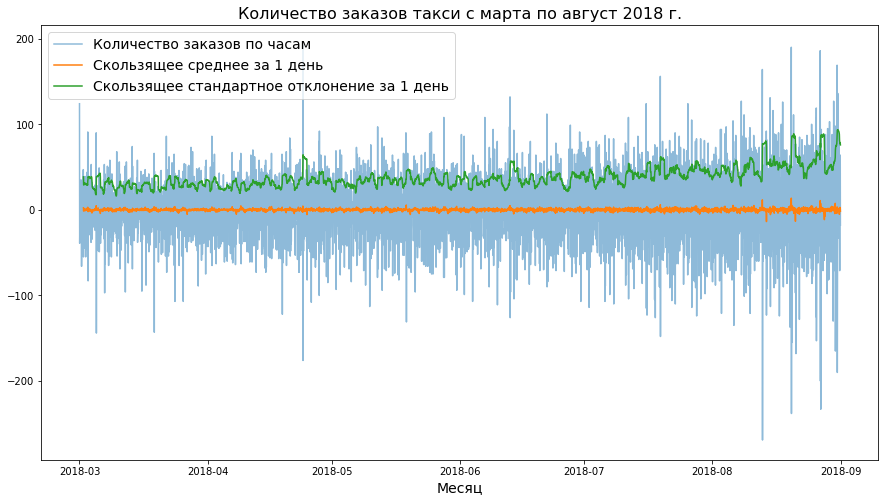

In [ ]:
# разность временного ряда
shifted_data = data_1h - data_1h.shift(fill_value=0)

plt.figure(figsize = (15,8))

# поочередно зададим кривые
plt.plot(shifted_data, label = 'Количество заказов по часам', alpha = 0.5)
plt.plot(shifted_data.rolling(24).mean(), label = 'Скользящее среднее за 1 день')
plt.plot(shifted_data.rolling(24).std(), label = 'Скользящее стандартное отклонение за 1 день')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.xlabel('Месяц', fontsize = 14)
plt.title('Количество заказов такси с марта по август 2018 г.', fontsize = 16)

plt.show()

Визуально ряд стал более стационарным, повторим тест Дики-Фуллера:

In [ ]:
adf_test = adfuller(shifted_data['num_orders'])
print('p-value = ', adf_test[1])

p-value =  1.0915609954407956e-28


Согласно результатам теста ряд действительно стал более стационарным.

### Автокорреляция

Несмотря на то, что тест говорит о стационарности ряда, построим автокорреляционную функцию и проверим наличие зависимостей, сравним исходный ряд с его разностью.

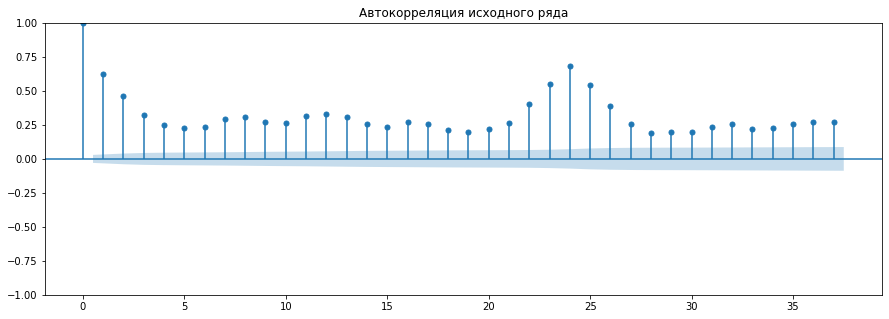

In [ ]:
rcParams['figure.figsize'] = 15, 5
fig = tsaplots.plot_acf(data_1h)
plt.title('Автокорреляция исходного ряда')
plt.show()

Как видно на графике, коррелляции есть и они достаточно сильные, скорее всего это зависимость ряда от дня недели. Построим автокорреляционную функцию для разности ряда:

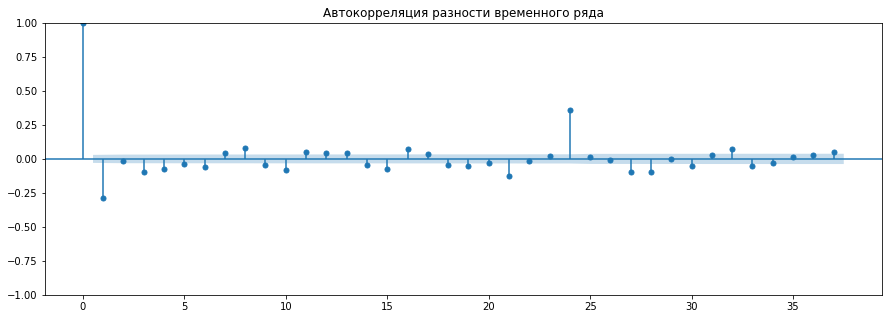

In [ ]:
rcParams['figure.figsize'] = 15, 5
fig = tsaplots.plot_acf(shifted_data)
plt.title('Автокорреляция разности временного ряда')
plt.show()

Автокорреляционных зависимостей стало меньше, ряд действительно становится более стационарным, четкой сезонности и тренда выявить уже нельзя.

### Вывод

На этапе анализа временного ряда были выявлены следующие закономерности:

- наибольшим спросом услуги такси пользуются в понедельник и пятницу, наименьшим - во вторник и воскресенье;
- ближе к вечеру и до 00.00 спрос на такси повышается, а затем до утра резко падает, также спрос повышается в районе 15.00;
- присутствует тренд к постепенному повышению общего количества заказов такси в данном сервисе.

## Обучение

### Создание признаков

Для построения прогнозов необходимо создать признаки, на которых будет обучаться модель. Напишем функцию которая добавит:

- календарные признаки;
- отстающие значения;
- скользящее среднее.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):

    data['dayofweek'] = data.index.dayofweek
    data['hour'] =  data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data_1h, 24, 24)

data_1h.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим ряд на обучающую и тестовую выборки в соотношении 90/10 соответственно:

In [ ]:
train, test = train_test_split(data_1h, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [ ]:
print('Размер тренировочной выборки,%:',round(len(train)/len(data_1h)*100,1))
print('Размер тестовой выборки,%:',round(len(test)/len(data_1h)*100,1))

Размер тренировочной выборки,%: 89.4
Размер тестовой выборки,%: 10.0


Проверим, не перемешались ли данные:

In [ ]:
print(train.index.max())
print(test.index.min())

2018-08-13 13:00:00
2018-08-13 14:00:00


### Выбор лучшей модели

#### Ridge, Lasso и ElasticNet

In [ ]:
def RegressionModelTraining(x_train, y_train):
    model_dict = {
        "Ridge": Ridge(random_state = 123, max_iter =10000),
        "Lasso": Lasso(random_state = 123, max_iter =10000),
        "ElasticNet": ElasticNet(random_state = 123, max_iter =10000)
    }

    for model_name, model in model_dict.items() :

        alpha_list = [1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 2, 4, 7, 10, 20, 30, 55, 100]
        param_grid = {'alpha': alpha_list}

        time_series_cv = TimeSeriesSplit(n_splits=5).split(x_train)

        grid_search = GridSearchCV(model,
                                   param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=time_series_cv)
        grid_search.fit(x_train, y_train)

        rmse = round((-grid_search.best_score_)**0.5, 4)
        best_alpha = grid_search.best_params_['alpha']

        print(model_name, '|', "RMSE =", rmse, '|', 'alpha', best_alpha)

In [ ]:
RegressionModelTraining(features_train, target_train)

Ridge | RMSE = 27.3603 | alpha 100
Lasso | RMSE = 27.2788 | alpha 7
ElasticNet | RMSE = 27.2852 | alpha 10


Все три модели показали близкий результат и преодолели пороговое значение качества на кросс-валидации.

#### Random Forest Regressor

In [ ]:
param_grid = {'max_depth': [5,10,15,20,25,30],
              'n_estimators':[30,40,50,60,70]}

time_series_cv = TimeSeriesSplit(n_splits=5).split(features_train)

grid_search = GridSearchCV(RandomForestRegressor(random_state=123),
                           param_grid,
                           scoring='neg_mean_squared_error',
                           cv=time_series_cv)
grid_search.fit(features_train, target_train)

rmse = round((-grid_search.best_score_)**0.5, 3)
best_params = grid_search.best_params_

print('RandomForestRegressor', '|', "RMSE =", rmse, '|', 'best_params', best_params)

RandomForestRegressor | RMSE = 25.57 | best_params {'max_depth': 30, 'n_estimators': 70}


Результат случайного леса чуть лучше, чем у регрессии. Значение метрики также ниже порогового.

#### LGBMRegressor

In [ ]:
param_grid = {'max_depth': [5,10,15,20,30],
              'learning_rate': [0.006,0.01,0.014,0.02],
              'num_leaves' : [7, 14, 21, 28, 31,]}

time_series_cv = TimeSeriesSplit(n_splits=5).split(features_train)

grid_search = GridSearchCV(LGBMRegressor(random_state = 123),
                           param_grid,
                           scoring='neg_mean_squared_error',
                           cv=time_series_cv)
grid_search.fit(features_train, target_train)

rmse = round((-grid_search.best_score_)**0.5, 3)
best_params = grid_search.best_params_

print('LGBMRegressor', '|', "RMSE =", rmse, '|', 'best_params', best_params)

LGBMRegressor | RMSE = 26.697 | best_params {'learning_rate': 0.02, 'max_depth': 15, 'num_leaves': 31}


Модель на основе библиотеки LightGBM показала неплохой результат на кросс-валидации, но значение метрики больше, чем у случайного леса.

За прототип модели для сервиса такси возьмем RandomForestRegressor и проверим его на тестовых данных.

## Тестирование

### Проверка на тестовых данных

Проверим модель случайного леса на тестовых данных с найденными оптимальными параметрами:

In [ ]:
rf = RandomForestRegressor(max_depth = 30, n_estimators = 70, random_state = 124)
rf.fit(features_train, target_train)
preds = rf.predict(features_test)
print("RMSE на тестовой выборке:", mean_squared_error(target_test,preds,squared=False))

RMSE на тестовой выборке: 43.062557185890945


Значение метрики ниже порогового, визуализируем прогноз:

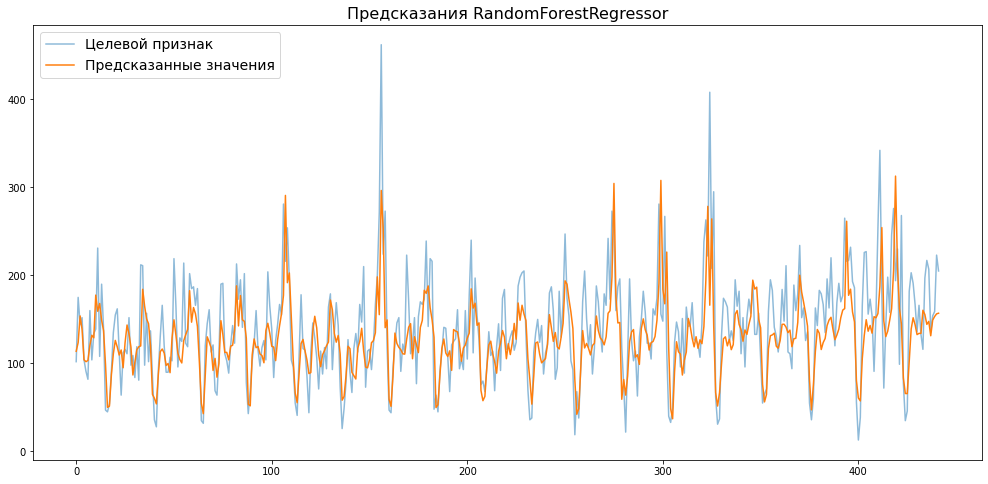

In [ ]:
plt.figure(figsize = (17,8))

plt.plot(target_test.values, label = 'Целевой признак', alpha = 0.5)
plt.plot(preds, label = 'Предсказанные значения')

plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.title('Предсказания RandomForestRegressor', fontsize = 16)

plt.show()

В целом модель неплохо предсказывает направления временного ряда, ошибки в основном в нахождении крайних значений.

### Бейзлайн

В качестве бейзлайна возьмем прогноз предыдущим значением ряда:

In [ ]:
train, test = train_test_split(data_1h, shuffle=False, test_size=0.1)

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print("RMSE бейзлайна:", mean_squared_error(test,pred_previous,squared=False))
print("RMSE итоговой модели:", mean_squared_error(target_test,preds,squared=False))

RMSE бейзлайна: 53.397853922145295
RMSE итоговой модели: 43.062557185890945


Значение метрики модели меньше на 10 единиц, а значит прототип проходит проверку на адекватность.

### Feature importance

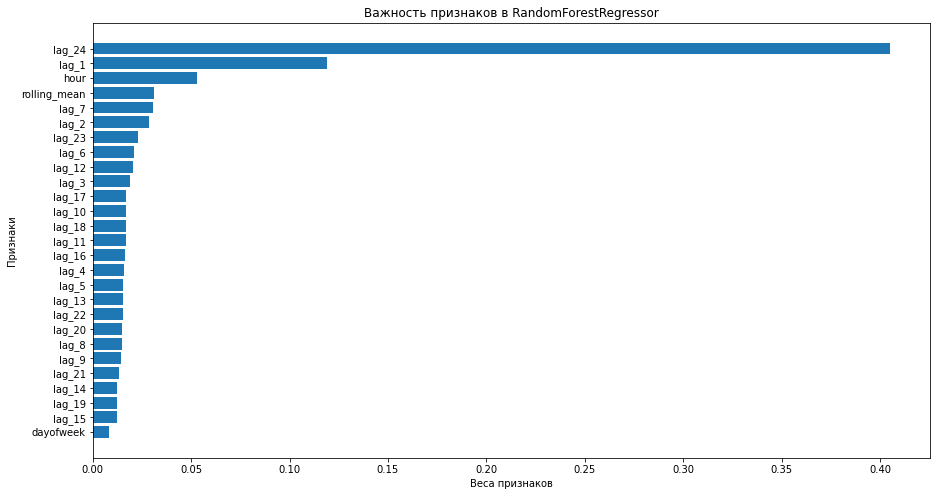

In [ ]:
importances = rf.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
ax.set_yticklabels(np.array(features_train.columns)[indices])
ax.set_xlabel('Веса признаков')
ax.set_ylabel('Признаки')
ax.set_title('Важность признаков в RandomForestRegressor')

plt.show()

Самые важные признаки для случайного леса - последний и первый лаги, час и скользящее среднее.

## Итоговый вывод

Задача проекта заключалась в том, чтобы построить модель, которая могла прогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. В качестве метрики был взят корень из среднеквадратической ошибки (RMSE) c пороговым значением 48.

Нами было протестировано 2 вида моделей:

- простые линейные модели (Lasso, Ridge и ElasticNet);
- ансамблевые модели (случайный лес и градиентный бустинг).

Лучше всего с предсказанием справилась модель на основе случайного леса, пороговое значение метрики на тестовой выборке было преодолено, проверку на адекватность модель проходит.

Таким образом, в качестве прототипа модели для предсказания количества заказов такси на следующий час можно порекомендовать использовать **Random Forest Regressor**.